In [1]:
from openbb import obb
from libs.backtester import Backtester
from backtesting import Strategy
#from backtesting.lib import crossover
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np

plt.rcParams["figure.figsize"] = (15,7)
plt.style.use("dark_background")
pd.set_option('display.max_columns', None)

from dotenv import dotenv_values

config = dotenv_values(".env") 
obb.account.login(pat=config['OPENBB_PAT'])

import libs.utils

In [2]:
def capitalize_df_cols(df):
    mapper = { col: col.capitalize()  for col in df.columns }
    df.rename( mapper, axis=1, inplace=True)

In [3]:
start_date = '1999-01-01'
end_date = '2001-01-01'
price_qqq = obb.equity.price.historical('QQQ', start_date=start_date, end_date=end_date, provider='fmp').to_dataframe()
capitalize_df_cols(price_qqq)
price_qqq.head()

,Open,High,Low,Close,Volume,Vwap,Adj_close,Unadjusted_volume,Change,Change_percent
date,,,,,,,,,,
1999-03-10,51.13,51.16,50.28,51.06,5232202,50.9075,43.53,5232202.0,-0.06250,-0.001369
1999-03-11,51.44,51.73,50.31,51.31,9688602,51.1975,43.75,9688602.0,-0.12500,-0.002527
1999-03-12,51.13,51.16,49.66,50.06,8743602,50.5025,42.68,8743602.0,-1.06000,-0.020900
1999-03-15,50.44,51.56,49.91,51.50,6369000,50.8525,43.91,6369000.0,1.06000,0.021000
1999-03-16,51.72,52.16,51.16,51.94,4905800,51.7450,44.28,4905800.0,0.21875,0.004254


In [4]:
trates = obb.fixedincome.government.treasury_rates(start_date=start_date, end_date=end_date).to_dataframe()
capitalize_df_cols(trates)
trates.head()

Exception ignored in: <function _ProactorBasePipeTransport.__del__ at 0x000001E0993D7EE0>
Traceback (most recent call last):
  File "c:\Users\User\anaconda3\envs\research\lib\asyncio\proactor_events.py", line 116, in __del__
    self.close()
  File "c:\Users\User\anaconda3\envs\research\lib\asyncio\proactor_events.py", line 108, in close
    self._loop.call_soon(self._call_connection_lost, None)
  File "c:\Users\User\anaconda3\envs\research\lib\asyncio\base_events.py", line 751, in call_soon
    self._check_closed()
  File "c:\Users\User\anaconda3\envs\research\lib\asyncio\base_events.py", line 515, in _check_closed
    raise RuntimeError('Event loop is closed')
RuntimeError: Event loop is closed


,Month_3,Month_6,Year_1,Year_2,Year_3,Year_5,Year_7,Year_10,Year_20,Year_30
date,,,,,,,,,,
1999-01-04,0.0449,0.0457,0.0458,0.0458,0.0457,0.0457,0.0475,0.0469,0.0542,0.0515
1999-01-05,0.0448,0.0457,0.0456,0.0464,0.0464,0.0462,0.0480,0.0474,0.0548,0.0521
1999-01-06,0.0447,0.0455,0.0453,0.0462,0.0462,0.0461,0.0476,0.0473,0.0542,0.0517
1999-01-07,0.0444,0.0449,0.0451,0.0463,0.0463,0.0462,0.0482,0.0477,0.0548,0.0523
1999-01-08,0.0448,0.0453,0.0457,0.0471,0.0471,0.0472,0.0492,0.0486,0.0557,0.0526


In [5]:
_df = pd.merge(price_qqq, trates[['Year_1']], how='inner', left_index=True, right_index=True)
_df['Returns'] = _df['Close'] - _df['Open']
_df['Returns_from_t0'] = ( _df['Close'] / _df['Open'].iloc[0] ) - 1
_df['Trates_1y'] = pd.to_numeric(_df['Year_1'], errors='coerce').fillna(0)
_df['Excess_returns'] = _df['Returns_from_t0'] - _df['Trates_1y']
_df['Sharpe'] = _df['Excess_returns'] / _df['Returns'].expanding().std()
# _df['Excess_returns'] = _df['Returns'] - _df['Trates_1y']
# _df['Sharpe'] = _df['Excess_returns'] / _df['Returns'].expanding().std()
ema_a = 5
ema_b = 20
_df[f'Sharpe_EMA_{ema_a}'] = ta.ema(_df['Sharpe'], ema_a).fillna(0)
_df[f'Sharpe_EMA_{ema_b}'] = ta.ema(_df['Sharpe'], ema_b).fillna(0)
_df

,Open,High,Low,Close,Volume,Vwap,Adj_close,Unadjusted_volume,Change,Change_percent,Year_1,Returns,Returns_from_t0,Trates_1y,Excess_returns,Sharpe,Sharpe_EMA_5,Sharpe_EMA_20
date,,,,,,,,,,,,,,,,,,
1999-03-10,51.13,51.16,50.28,51.06,5232202,50.9075,43.53,5232202.0,-0.06250,-0.001369,0.0475,-0.07,-0.001369,0.0475,-0.048869,NaN,0.000000,0.000000
1999-03-11,51.44,51.73,50.31,51.31,9688602,51.1975,43.75,9688602.0,-0.12500,-0.002527,0.0477,-0.13,0.003520,0.0477,-0.044180,-1.041322,0.000000,0.000000
1999-03-12,51.13,51.16,49.66,50.06,8743602,50.5025,42.68,8743602.0,-1.06000,-0.020900,0.0476,-1.07,-0.020927,0.0476,-0.068527,-0.122188,0.000000,0.000000
1999-03-15,50.44,51.56,49.91,51.50,6369000,50.8525,43.91,6369000.0,1.06000,0.021000,0.0476,1.06,0.007236,0.0476,-0.040364,-0.046308,0.000000,0.000000
1999-03-16,51.72,52.16,51.16,51.94,4905800,51.7450,44.28,4905800.0,0.21875,0.004254,0.0474,0.22,0.015842,0.0474,-0.031558,-0.041272,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-12-22,57.63,60.75,57.63,60.50,57243008,59.1275,51.58,57243008.0,2.88000,0.049800,0.0525,2.87,0.183258,0.0525,0.130758,0.059755,0.052235,0.098940
2000-12-26,60.59,61.92,58.00,60.88,37078896,60.3475,51.90,37078896.0,0.28125,0.004786,0.0531,0.29,0.190690,0.0531,0.137590,0.062944,0.055804,0.095512
2000-12-27,59.69,62.19,58.94,61.56,33952496,60.5950,52.49,33952496.0,1.88000,0.031300,0.0532,1.87,0.203990,0.0532,0.150790,0.068992,0.060200,0.092986


<Axes: xlabel='date'>

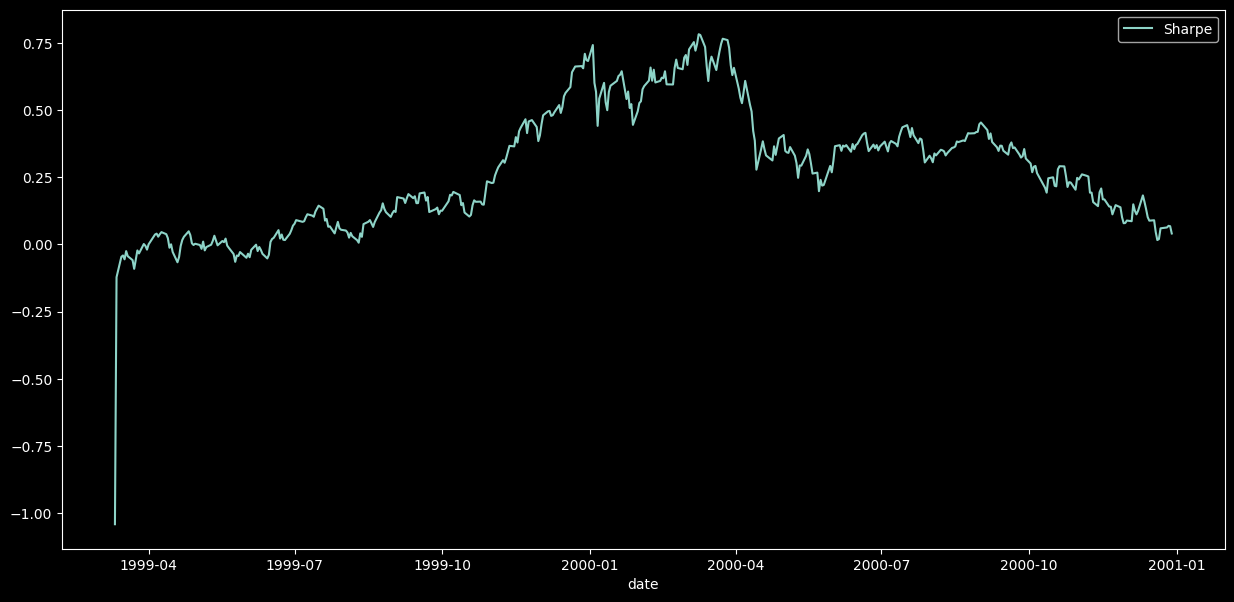

In [6]:
#_df[['Sharpe', f'Sharpe_EMA_{ema_a}', f'Sharpe_EMA_{ema_b}']].plot()
_df[['Sharpe']].plot()

<Axes: xlabel='Sharpe', ylabel='y'>

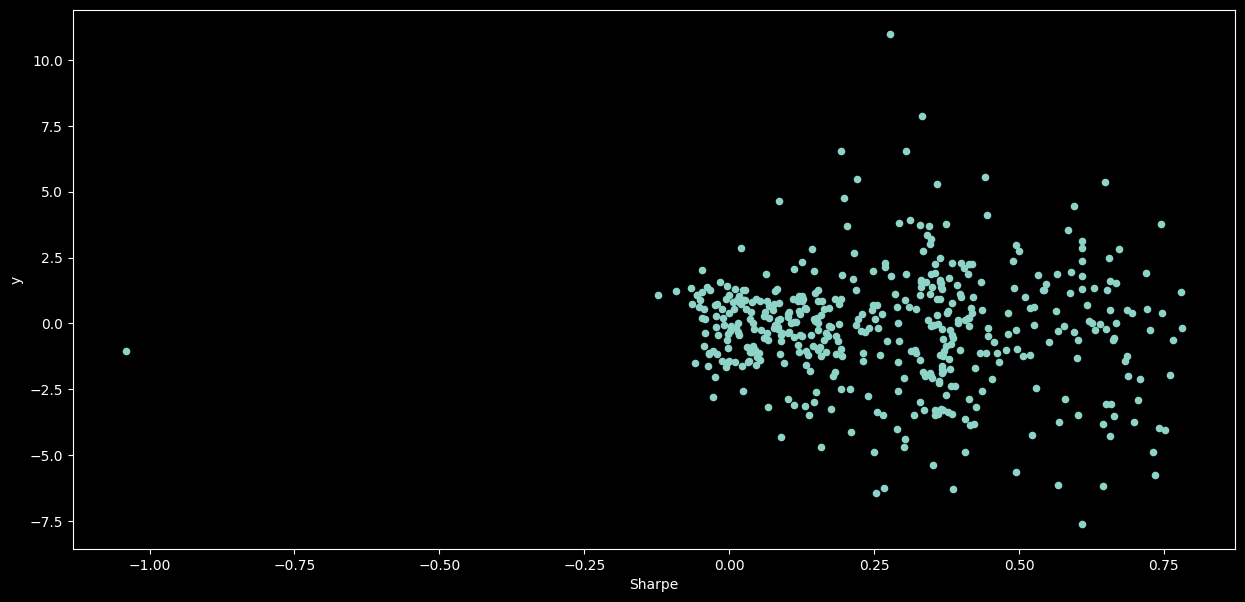

In [7]:
_df['y'] = _df['Returns'].shift(-1)
_df.plot.scatter(x='Sharpe', y='y')

```
df[f'Sharpe Signal {ema_a}'] = ( df[f'Sharpe Ema {ema_a}'] - df['Sharpe'] ).apply(lambda v: v if v > 0 else 0)
df[f'Sharpe Signal {ema_b}'] = ( df[f'Sharpe Ema {ema_b}'] - df['Sharpe'] ).apply(lambda v: v if v > 0 else 0)

def crossover_signal(A, B):
    signals = []
    for i, (a, b) in enumerate( zip(A, B) ):
        signal = 0
        if i > 0 and a < b and A[i-1] > B[i-1]:
            signal = 1 * (a+b)/2.0
        signals.append(signal)
    return signals

df['Sharpe Signal'] = crossover_signal(df[f'Sharpe Signal {ema_a}'].values, df[f'Sharpe Signal {ema_b}'].values)
df
```

```
df['Sharpe below'] = (df['Sharpe Ema 20'] - df['Sharpe']).apply(lambda v: v if v > 0 else 0)
```

In [8]:
df_signals = pd.read_csv("../data/QQQ_1999_2001_marked.csv")
df_signals.set_index(keys=["date"], inplace=True)
df_signals.index = pd.to_datetime(df_signals.index)
df_signals = df_signals[df_signals['Sides'].isin(["BUY", "SELL"])]
df_signals.head()

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,Sides
date,,,,,,,,,
1999-03-23,42.907798,43.067703,41.548607,41.628559,41.628559,10962400,0,0,BUY
1999-04-07,47.864823,47.971426,45.919315,46.932045,46.932045,11923600,0,0,SELL
1999-04-19,44.613429,44.986540,41.795108,42.241508,42.241508,19460600,0,0,BUY
1999-04-27,48.611031,48.850888,46.912043,47.518349,47.518349,16482800,0,0,SELL
1999-05-26,43.067680,43.867204,41.735140,43.693974,43.693974,26772000,0,0,BUY


In [9]:
df = _df.merge(df_signals[['Sides']], how="left", left_index=True, right_index=True)
df['Signals'] = df['Sides'].apply(lambda v : 1 if v == "BUY" else -1 if v == "SELL" else 0)
df

,Open,High,Low,Close,Volume,Vwap,Adj_close,Unadjusted_volume,Change,Change_percent,Year_1,Returns,Returns_from_t0,Trates_1y,Excess_returns,Sharpe,Sharpe_EMA_5,Sharpe_EMA_20,y,Sides,Signals
date,,,,,,,,,,,,,,,,,,,,,
1999-03-10,51.13,51.16,50.28,51.06,5232202,50.9075,43.53,5232202.0,-0.06250,-0.001369,0.0475,-0.07,-0.001369,0.0475,-0.048869,NaN,0.000000,0.000000,-0.13,NaN,0
1999-03-11,51.44,51.73,50.31,51.31,9688602,51.1975,43.75,9688602.0,-0.12500,-0.002527,0.0477,-0.13,0.003520,0.0477,-0.044180,-1.041322,0.000000,0.000000,-1.07,NaN,0
1999-03-12,51.13,51.16,49.66,50.06,8743602,50.5025,42.68,8743602.0,-1.06000,-0.020900,0.0476,-1.07,-0.020927,0.0476,-0.068527,-0.122188,0.000000,0.000000,1.06,NaN,0
1999-03-15,50.44,51.56,49.91,51.50,6369000,50.8525,43.91,6369000.0,1.06000,0.021000,0.0476,1.06,0.007236,0.0476,-0.040364,-0.046308,0.000000,0.000000,0.22,NaN,0
1999-03-16,51.72,52.16,51.16,51.94,4905800,51.7450,44.28,4905800.0,0.21875,0.004254,0.0474,0.22,0.015842,0.0474,-0.031558,-0.041272,0.000000,0.000000,-0.38,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-12-22,57.63,60.75,57.63,60.50,57243008,59.1275,51.58,57243008.0,2.88000,0.049800,0.0525,2.87,0.183258,0.0525,0.130758,0.059755,0.052235,0.098940,0.29,NaN,0
2000-12-26,60.59,61.92,58.00,60.88,37078896,60.3475,51.90,37078896.0,0.28125,0.004786,0.0531,0.29,0.190690,0.0531,0.137590,0.062944,0.055804,0.095512,1.87,NaN,0
2000-12-27,59.69,62.19,58.94,61.56,33952496,60.5950,52.49,33952496.0,1.88000,0.031300,0.0532,1.87,0.203990,0.0532,0.150790,0.068992,0.060200,0.092986,0.66,NaN,0


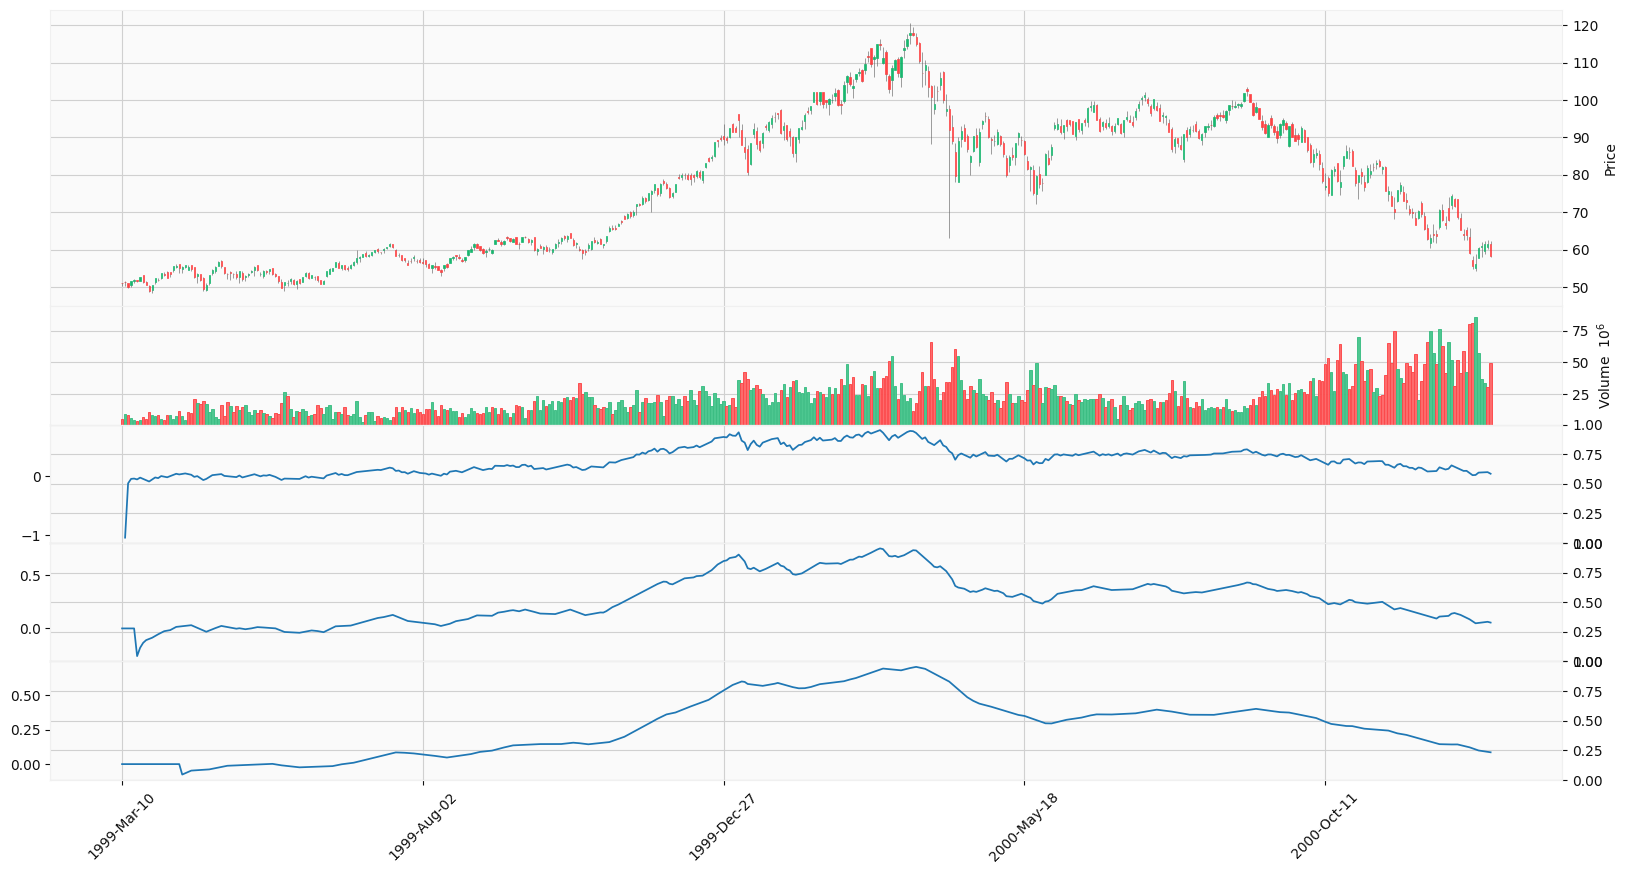

In [12]:
libs.utils.plot_graph(df, panel_cols_regex=['Sharpe'])

In [13]:
def extract(df, column):
    return df[column]

class SharpeReversion(Strategy):
    NAME = 'sharpe reversion'
    
    def init(self):
        super().init()
        self.sharpe = self.I(extract, df=self.data, column=f'Sharpe')
        self.vwma_5d = self.I(ta.vwma, close=self.data.df['Close'], volume=self.data.df['Volume'], length=5, overlay=True)
        self.vwma_20d = self.I(ta.vwma, close=self.data.df['Close'], volume=self.data.df['Volume'], length=20, overlay=True)
        
    def next(self):
        super().next()
        pass
        
                
bt = Backtester(strategy=SharpeReversion, data=df, capital=100_000, commission=0.00)
bt.run()

Start                     1999-03-10 00:00:00
End                       2000-12-29 00:00:00
Duration                    660 days 00:00:00
Exposure Time [%]                         0.0
Equity Final [$]                      10000.0
Equity Peak [$]                       10000.0
Return [%]                                0.0
Buy & Hold Return [%]               14.336075
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     0.0
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Max. Drawdown [%]                        -0.0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                    0
Win Rate [%]                              NaN
Best Trade [%]                            NaN
Worst Trade [%]                           NaN
Avg. Trade [%]                    

In [ ]:
# def extract(df, column):
#     return df[column]

# class Alpha1(Strategy):
#     NAME = 'side charted 1999-2001'
    
#     def init(self):
#         super().init()
#         self.signal = self.I(extract, df=self.data, column=f'Signals')
#         self.vwma_5d = self.I(ta.vwma, close=self.data.df['Close'], volume=self.data.df['Volume'], length=5, overlay=True)
#         self.vwma_20d = self.I(ta.vwma, close=self.data.df['Close'], volume=self.data.df['Volume'], length=20, overlay=True)
#         self.bband = self.I(ta.bbands, close=self.data.df['Close'], length=14, talib=True, overlay=False)
        
#     def next(self):
#         super().next()
#         if self.signal[-1] == 1:
#             self.buy(size=0.25)
#         elif self.signal[-1] == -1:
#             #self.sell(size=0.25)
#             self.position.close()
#         else:
#             pass
        
                
# bt = Backtester(strategy=Alpha1, data=df, capital=100_000, commission=0.00)
# bt.run()

### Feature Engineering

In [ ]:
obb.economy.short_term_interest_rate().to_dataframe()

,value,country
date,,
1964-06-30,3.86,united_states
1964-07-31,3.87,united_states
1964-08-31,3.85,united_states
1964-09-30,3.87,united_states
1964-10-31,3.94,united_states
...,...,...
2024-02-29,5.22,united_states
2024-03-31,5.29,united_states
2024-04-30,5.33,united_states


```
import talib
def get_enex(closes, rsi, rsi_dist, is_uptrend, is_downtrend, above_bb, beneath_bb, atr_perc, rrr, max_position_age):
    entries = np.zeros(closes.shape[0])
    exits = np.zeros(closes.shape[0])
    short_entries = np.zeros(closes.shape[0])
    short_exits = np.zeros(closes.shape[0])

    pos = 0
    entry_i = 0
    lower_limit = 0
    upper_limit = 0

    for i in range(closes.shape[0]):
        if pos == 0:
            if beneath_bb[i] and is_uptrend[i] and rsi[i] <= 50-rsi_dist:
                pos = 1
                entries[i] = True
                entry_i = i
                lower_limit = (1 - atr_perc[i]) * closes[i]
                upper_limit = (1 + atr_perc[i] * rrr) * closes[i]

            elif above_bb[i] and is_downtrend[i] and rsi[i] >= 50+rsi_dist:
                pos = -1
                short_entries[i] = True
                entry_i = i
                lower_limit = (1 - atr_perc[i] * rrr) * closes[i]
                upper_limit = (1 + atr_perc[i]) * closes[i]
        else:
            if closes[i] > upper_limit or closes[i] < lower_limit or i - entry_i > max_position_age:
                if pos == 1:
                    exits[i] = True
                else:
                    short_exits[i] = True
                pos = 0

    return entries, exits, short_entries, short_exits


def get_enex_easily(o, h, l, c, v, fast_ema_period, slow_ema_period, trend_ma_period, trend_threshold, bb_period, bb_std, atr_period, atr_factor, rrr, rsi_period, rsi_dist, max_position_age):
    atr_perc = (talib.ATR(h, l, c, timeperiod=atr_period) / c) * atr_factor

    rsi = talib.RSI(c, timeperiod=rsi_period)

    fast_ema = talib.EMA(c, timeperiod=fast_ema_period)
    slow_ema = talib.EMA(c, timeperiod=slow_ema_period)
    if trend_ma_period <= 1:
        is_uptrend   = fast_ema > slow_ema
        is_downtrend = fast_ema < slow_ema
    else:
        is_uptrend   = talib.SMA(np.array(fast_ema > slow_ema, dtype=np.float64), timeperiod=trend_ma_period) >= trend_threshold
        is_downtrend = talib.SMA(np.array(fast_ema < slow_ema, dtype=np.float64), timeperiod=trend_ma_period) >= trend_threshold

    upper_bb, _, lower_bb = talib.BBANDS(c, bb_period, bb_std, bb_std)
    above_bb = c > upper_bb
    beneath_bb = c < lower_bb

    return get_enex(c, rsi, rsi_dist, is_uptrend, is_downtrend, above_bb, beneath_bb, atr_perc, rrr, max_position_age)


params = {
    "fast_ema_period": 5,
    "slow_ema_period": 14,
    "bb_period": 14,
    "bb_std": 0,
    "atr_period": 5,
    "atr_factor": 1,
    "rrr": 1,
    "rsi_period": 14,
    "rsi_dist": 0,
    "trend_ma_period": 1,
    "trend_threshold": 1
}

universe = price_qqq.copy(deep=True)
entries, exits, short_entries, short_exits = get_enex_easily(universe['Open'], 
                                                             universe['High'], 
                                                             universe['Low'], 
                                                             universe['Close'], 
                                                             universe['Volume'], 
                                                             **params, max_position_age=12*24*5)

df = pd.DataFrame({ 'date' : universe.index, 'entries': entries, 'exits': exits })
df[ (df['entries'] > 0) | (df['exits'] > 0) ]
```

In [ ]:
universe = price_qqq.copy(deep=True)
universe['Returns'] = ( universe['Close'] / universe['Open'] ) - 1
universe['Open_Close_Pct'] = ( universe['Open'] / universe['Close'].shift(1) ) - 1
universe['Close_Close_Pct'] = ( universe['Close'] / universe['Close'].shift(1) ) - 1
universe['Body'] = np.abs(universe['Open'] - universe['Close'])
universe['VWMA_10_Pct'] = ( ta.vwma(close=universe['Close'], volume=universe['Volume'], length=10) / universe['Close'] ) - 1
universe['RSI_14'] = ta.rsi(close=universe['Close'], length=14) / 100
universe['Zscore'] = ta.zscore(close=universe['Close'], length=14)
# universe = universe.join(other=ta.bbands(close=universe['Close'], length=14), how='outer')
# universe.rename({
#     'BBL_14_2.0': 'BBand_Low',
#     'BBM_14_2.0': 'BBand_Mid',
#     'BBU_14_2.0': 'BBand_Upper',
#     'BBB_14_2.0': 'BBand_Bandwidth',
#     'BBP_14_2.0': 'BBand_Pct'
# }, axis=1, inplace=True)

universe = universe.join(other=trates[['Year_1']], how='outer')
universe['Sharpe'] = (universe['Returns'] - ( pd.to_numeric(universe['Year_1'], errors='coerce').fillna(0) / 100.0 ) ) / universe['Returns'].expanding().std()
universe['Drawdown'] = ( universe['Close'] / universe['High'].rolling(14).max() ) - 1.0
universe['Drawup'] = ( universe['Close'] / universe['Low'].rolling(14).min() ) - 1.0

universe.dropna(axis=0, inplace=True)

#universe['y'] = universe['Returns'].shift(-1)

universe = universe.join(other=df_signals['Sides'], how='left').rename({'Sides': 'y'}, axis=1)
universe['y'] = universe['y'].map({'BUY': 1, 'SELL': -1}).fillna(0)

display( universe.head() )
display( universe.shape )
display( universe.columns )

,Open,High,Low,Close,Volume,Vwap,Adj_close,Unadjusted_volume,Change,Change_percent,Returns,Open_Close_Pct,Close_Close_Pct,Body,VWMA_10_Pct,RSI_14,Zscore,Year_1,Sharpe,Drawdown,Drawup,y
date,,,,,,,,,,,,,,,,,,,,,,
1999-03-30,53.56,54.00,53.03,53.25,4940600.0,53.4600,45.40,4940600.0,-0.3125,-0.005788,-0.005788,-0.001305,-0.007086,0.31,-0.036010,0.573837,1.432844,0.0472,-0.311807,-0.013889,0.097938,0.0
1999-03-31,54.13,54.19,52.31,52.47,8256602.0,53.2750,44.73,8256602.0,-1.6600,-0.030700,-0.030667,0.016526,-0.014648,1.66,-0.019405,0.543076,0.713761,0.0472,-1.497299,-0.031740,0.081856,0.0
1999-04-01,54.00,54.06,52.69,53.56,8715796.0,53.5775,45.67,8715796.0,-0.4375,-0.008148,-0.008148,0.029160,0.020774,0.44,-0.036125,0.577186,1.364576,0.0473,-0.427160,-0.011626,0.104330,0.0
1999-04-22,53.66,54.75,53.30,54.59,13630602.0,54.0750,46.54,13630602.0,0.9375,0.017300,0.017331,0.009406,0.026900,0.93,-0.034222,0.558508,0.389581,0.0473,0.717236,-0.029511,0.117731,0.0
1999-04-23,54.31,55.72,53.75,55.31,7064400.0,54.7725,47.16,7064400.0,1.0000,0.018400,0.018413,-0.005129,0.013189,1.00,-0.046421,0.577994,0.776594,0.0471,0.766658,-0.016711,0.132473,0.0


(429, 22)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Vwap', 'Adj_close',
       'Unadjusted_volume', 'Change', 'Change_percent', 'Returns',
       'Open_Close_Pct', 'Close_Close_Pct', 'Body', 'VWMA_10_Pct', 'RSI_14',
       'Zscore', 'Year_1', 'Sharpe', 'Drawdown', 'Drawup', 'y'],
      dtype='object')

<Axes: xlabel='Sharpe', ylabel='Drawdown'>

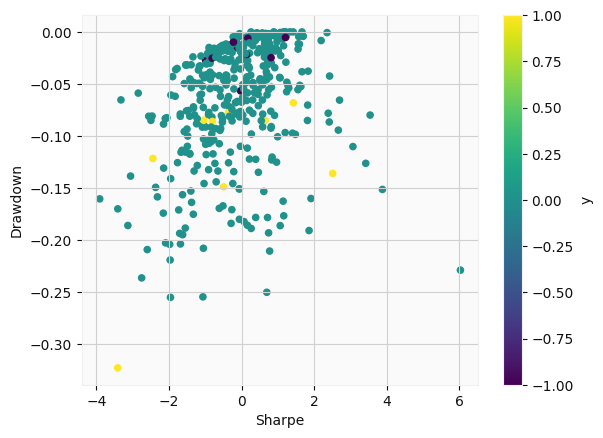

In [ ]:
universe.plot.scatter(x='Sharpe', y='Drawdown', c='y')

In [ ]:
features = pd.DataFrame()
features['Returns'] = universe['Returns']
features['Zscore'] = universe['Zscore']

features.head()

,Returns,Zscore
date,,
1999-03-30,-0.005788,1.432844
1999-03-31,-0.030667,0.713761
1999-04-01,-0.008148,1.364576
1999-04-22,0.017331,0.389581
1999-04-23,0.018413,0.776594


```
def crossover_signal(A, B):
    signals = []
    for i, (a, b) in enumerate( zip(A, B) ):
        signal = 0
        if i > 0 and a < b and A[i-1] > B[i-1]:
            signal = 1 * (a+b)/2.0
        signals.append(signal)
    return signals

def sharpe_drawdown_crossing_indicator(df, window, smoothing_a, smoothing_b):
    sharpe = openbb.qa.sharpe(df['Close'], window=window)
    rolling_max = df['High'].rolling(window, min_periods=1).max()
    drawdown = (df['High']/rolling_max) - 1.0
    sharpe_drawdown = (sharpe * drawdown).apply(lambda v: v if v > 0 else 0)
    sharpe_drawdown_a = ta.sma(sharpe_drawdown, length=smoothing_a)
    sharpe_drawdown_b = ta.sma(sharpe_drawdown, length=smoothing_b)
    return crossover_signal(sharpe_drawdown_a.values, sharpe_drawdown_b.values)
    # TODO: if past 5 days has signal go again
    # TODO: if past 10 days has trades closed due to Low price, and vwaps cross, go again
    

def _sharpe_rsi_drawdown(df, window):
    sharpe = openbb.qa.sharpe(df['Close'], window=window)
    rsi = ta.rsi(close=df['Close'], length=window)
    rolling_max = rsi.rolling(30, min_periods=1).max()
    rsi_drawdown = (rsi/rolling_max) - 1.0
    sharpe_rsi_drawdown = (sharpe * rsi_drawdown).apply(lambda v: v if v > 0 else 0)
    return sharpe_rsi_drawdown
    
def sharpe_rsi_drawdown_crossing_indicator(df, window, smoothing_a, smoothing_b):
    sharpe_rsi_drawdown = _sharpe_rsi_drawdown(df=df, window=window)
    sharpe_rsi_drawdown_sma_a = ta.sma(sharpe_rsi_drawdown, length=smoothing_a)
    sharpe_rsi_drawdown_sma_b = ta.sma(sharpe_rsi_drawdown, length=smoothing_b)
    return crossover_signal(sharpe_rsi_drawdown_sma_a.values, sharpe_rsi_drawdown_sma_b.values)

def rolling_stddev(df, window):
    return df['Close'].rolling(window).std()

def stoploss_line(df, window, tolerance):
    stddev = rolling_stddev(df, window)
    offset = (1.0 + tolerance) * stddev
    return df['Low'] - offset

def vwapma_line(df, length):
    vwap = ta.vwap(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume'])
    return ta.sma(vwap, length=length)

class TQQQStrategy(Strategy):
    NAME = 'tqqq strategy'
    BUY_SIGNAL_THRESHOLD = 0.001
    STOPLOSS_TOLERANCE = 0.05
    
    def init(self):
        super().init()
        self.sharpe_drawdown_crossing = self.I(sharpe_rsi_drawdown_crossing_indicator, df=self.data.df, window=30, smoothing_a=10, smoothing_b=15)
        #self.b = self.I(sharpe_drawdown_crossing_indicator, df=self.data.df, window=30, smoothing_a=5, smoothing_b=15)
        # self.vwma_5d = self.I(ta.vwma, close=self.data.df['Close'], volume=self.data.df['Volume'], length=5, overlay=True)
        # self.vwma_20d = self.I(ta.vwma, close=self.data.df['Close'], volume=self.data.df['Volume'], length=20, overlay=True)
        self.vwma_5d = self.I(vwapma_line, df=self.data.df, length=5, overlay=True)
        self.vwma_20d = self.I(vwapma_line, df=self.data.df, length=10, overlay=True)
        self.stddev = self.I(rolling_stddev, df=self.data.df, window=30)
        self.stoploss = self.I(stoploss_line, df=self.data.df, window=30, tolerance=self.STOPLOSS_TOLERANCE, overlay=True)
        #self.roc = self.I(ta.roc, close=self.data.df['Close'], length=1)
        self.signal_count = 0
        
    def _signal_flag(self, flag, n=1):
        signal_off = not flag
        is_nth_signal = flag and self.signal_count == n
        return signal_off or is_nth_signal
    
    def _market_trading_down(self):
        vmwa_below = self.vwma_5d[-1] < self.vwma_20d[-1]
        open_below_vmwa = self.data.Open[-1] < self.vwma_5d[-1]
        close_below_vmwa = self.data.Close[-1] < self.vwma_5d[-1]
        return vmwa_below and close_below_vmwa #and open_below_vmwa
        
    def next(self):
        super().next()
        if self.position.size > 0:
            for trades in self.trades:
                trade_stoploss = trades.sl
                stoploss_t0 = self.stoploss[-1]
                trades.sl = max(trade_stoploss, stoploss_t0)
            
        signal = self.sharpe_drawdown_crossing[-1]
        max_signal_past_20d = max(self.sharpe_drawdown_crossing[-5:-1]) # past 10 days
        signal_memory_condition = False#not self._market_trading_down() and max_signal_past_20d >= self.BUY_SIGNAL_THRESHOLD > 0
        has_signal = signal >= self.BUY_SIGNAL_THRESHOLD or (self.position.size == 0 and signal_memory_condition)
        if has_signal:
            self.signal_count += 1
            if self._signal_flag(False):
                sl = self.stoploss[-1]
                self.buy(sl=sl, size=0.4)
            
            
#bt = Backtester(strategy=TQQQStrategy, data=openbb.stocks.load('TQQQ', start_date='2010-01-01', end_date='2012-01-01'), capital=10000, commission=0.002)
bt = Backtester(strategy=TQQQStrategy, data=openbb.stocks.load('QQQ', start_date='1995-01-01', end_date='2005-01-01'), capital=10000, commission=0.002)
stats = bt.run()
```